# Travelling Salesman Problem

In [1]:
%matplotlib inline

In [2]:
from numpy import *
from random import *
from math import exp
from copy import deepcopy
from itertools import cycle
from collections import deque
import matplotlib as matplotlib
import re

Definimos una solución como una permutación con su coste

In [3]:
class Route:
        
        def __init__(self, permutation, dist):
            self.permutation = deepcopy(array(permutation))
            self.dist = array(dist)
            self.update_cost()

        """Calculates cuadratic cost"""
        def update_cost(self):
            pairs = self.get_edges()
            self.cost = sum([self.dist[x,y] for (x,y) in pairs])
        
        def change_positions(self,i,j):
            # Intercambia dos ciudades del grafo
            self.permutation[i], self.permutation[j] = self.permutation[j], self.permutation[i]
            self.update_cost()
            
        def change_edges(self,i,j):
            # Intercambia dos aristas del grafo
            i,j = min(i,j), max(i,j)
            
            rev = self.permutation[i:j]
            rev = rev[::-1]
            self.permutation[i:j] = rev
            self.update_cost()
        
        def get_edges(self):
            shifted = append(self.permutation[1:], [self.permutation[0]])
            pairs = zip(self.permutation, shifted)
            return(pairs)
            

Implementación de la clase que albergará los datos del problema

In [104]:
class TSP:   
    
    #def prueba(self):
    #    return(Route(array(range(len(self.points))), self.dist))
    
    def __read (self, file):  
        f = open(file, 'r')
        match = '^[0-9].*'
        points = []
        
        for line in f:
            is_point = re.search(match, line)

            if is_point:
                x,y = map(float, line.split()[1:])
                points.append((x,y))
    
        return(points)
    
    
    def simulated_annealing(self, t_ini, max_iter, alpha):
        """Temperatura"""
        t = t_ini
        
        """Número de ciudades"""
        n = len(self.points)
        
        """Permutación"""
        permutation = array(range(n))
        shuffle(permutation)
        solution = Route(permutation, self.dist)
        best_solution = Route(permutation, self.dist)
        
        """Variables que controlan las iteraciones"""
        improvement = True
        i=0
        
        while i < max_iter:
            candidate = deepcopy(solution)
            
            # Generamos los índices de los arcos a cambiar
            u = randint(0, n-1)
            v = randint(u+1, n)   
            candidate.change_edges(u,v)
            
            """u = randint(0, n-1)
            v = randint(0, n-1)
            candidate.change_positions(u,v)"""
            
            diff_cost = candidate.cost - solution.cost
            
            if (diff_cost < 0 or random() < exp(-diff_cost*1.0/t)):
                solution = deepcopy(candidate)
        
                if (solution.cost < best_solution.cost):
                    best_solution = deepcopy(solution)
            
            """Esquema de enfriamiento"""
            t = alpha*t
            
            i+=1
        
        return best_solution
    
    def _make_permutation(self, edge_freq):
        edge_freq = array(edge_freq)
        n = len(edge_freq)
        prev = 0
        permutation = array([0]*n)
        visited = array([True] + [False]*(n-1))

        for i in range(1,n):
            min_freq = min_freq = float("inf")

            for j in where(visited == False)[0]:
                if not visited[j] and edge_freq[prev,j] < min_freq:
                    min_freq = edge_freq[prev,j]
                    selected = j

            visited[selected] = True
            prev = selected
            permutation[i] = prev

        return(permutation)
            
    
    
    def tabu_search(self, max_iter, max_vecinos, tabu_tenencia, aspiration_tol, limit_restart):
        """Número de ciudades"""
        n = len(self.points)
        
        """Permutación"""
        permutation = array(range(n))
        shuffle(permutation)
        candidate = Route(permutation, self.dist)
        best_solution = deepcopy(candidate)
        
        """Lista tabú de soluciones"""
        tabu_list = [None] * tabu_tenencia
        index = cycle(range(len(tabu_list)))
        
        """Lista de reinicialización"""
        best_list = deque([])
        non_improving = 0
        edge_freq = array([[0]*n]*n)
        restart = False
        
        i = 0
        
        while i < max_iter:                
            j = 0
            
            best_neighbour = None
            
            while i< max_iter and j < max_vecinos:
                
                if non_improving==limit_restart or restart:
                    u = random()
                    
                    if (u < prob_bs):
                        candidate = deepcopy(best_solution)
                    else: 
                        if ((u-prob_bs) < prob_greedy):
                            #candidate = Route(self._make_permutation(edge_freq), self.dist)
                        #else:
                            permutation = array(range(n))
                            shuffle(permutation)
                            candidate = Route(permutation, self.dist)

                    j = 0
                    non_improving = 0
                    
                    if best_neighbour is not None:
                        tabu_list[ next(index) ] = (u_tabu, v_tabu)
                    
                    best_neighbour = None
                    #tabu_list = [None] * int(coef_tenencia*n)
                    restart = False
                
                    
                # Generamos los índices de los arcos a cambiar
                    
                u = randint(0, n-1)
                v = randint(u+1, n)   
                candidate.change_edges(u,v)
                
                eval_solution = True
                
                
                # Si hay arcos comunes entre ambos
                if (set([(u,v)]) & set(tabu_list)):
                    eval_solution = False
                    
                    """Criterio de aspiración"""
                    if best_neighbour is not None and \
                       candidate.cost < aspiration_tol*best_solution.cost:
                        eval_solution = True

                if eval_solution:
                    if best_neighbour is None: 
                        best_neighbour = deepcopy(candidate)
                        u_tabu, v_tabu = u,v  
                    else:
                        if candidate.cost < best_neighbour.cost:
                            best_neighbour = deepcopy(candidate)
                            best_list.append(best_neighbour)
                            
                            for (p,q) in candidate.get_edges():
                                edge_freq[p,q] += 1;
                        
                            if candidate.cost < best_solution.cost:
                                best_solution = deepcopy(candidate)                      
                            
                        else:
                            non_improving += 1
                  
                j+=1
                i+=1
            """Fin de exploración del vecindario"""
            
            if best_neighbour is not None:
                candidate = deepcopy(best_neighbour)
                # Arcos del mejor vecino
                tabu_list[ next(index) ] = (u_tabu, v_tabu)
            else:
                restart = True
                tabu_list = [None] * tabu_tenencia
            
            
        """Fin de toda la exploración"""
        return best_solution
    
        
    def print_solution(self, solution):
        p_x = [ self.points[i][0] for i in solution.permutation ]
        p_y = [ self.points[i][1] for i in solution.permutation ]
        p_x = append(p_x, p_x[0])
        p_y = append(p_y, p_y[0])
        tol_x = 0.05 * mean(p_x)
        tol_y = 0.05 * mean(p_y)
        
        matplotlib.rcParams.update({'font.size': 18, 'lines.linewidth':3})
        matplotlib.pyplot.figure(figsize=(15,10))
        matplotlib.pyplot.xlim(min(p_x) - tol_x, max(p_x) + tol_x)
        matplotlib.pyplot.ylim(min(p_y) - tol_y, max(p_y) + tol_y)
        matplotlib.pyplot.plot(p_x, p_y, marker='o', color='red', markersize=7)
    
    def __init__(self, file):
        self.points = array(self.__read(file))
        self.dist = sqrt(
            [
                [dot(subtract(x,y),subtract(x,y)) for x in self.points] 
                for y in self.points
            ])


In [6]:
files = ['berlin52.tsp', 'ch150.tsp', 'd198.tsp', 'eil101.tsp']

problems = {}
sa_solutions = {}
ts_solutions = {}
best_solutions = {'berlin52': 7542,
                  'ch150': 6528,
                  'd198': 15780,
                  'eil101': 629}

In [29]:
semilla = 12345678

for f in files:
    seed(semilla)
    name = f[:-4]
    problems[name] = TSP(f)
    size = len(problems[name].points)
    n_iter = size*100
    alpha = 0.95
    sa_solutions[name] = problems[name].simulated_annealing(size*1e3, n_iter, alpha) 

/home/nuwanda/.local/lib/python2.7/site-packages/ipykernel/__main__.py:52: RuntimeWarning: overflow encountered in double_scalars


In [132]:
semilla = 12345678
f = 'eil101.tsp'

seed(semilla)
name = f[:-4]
problems[name] = TSP(f)
size = len(problems[name].points)
n_iter = size*100
aspiration_tol = 1.
limit_restart = 5
max_vecinos = 30
tabu_tenencia=int(size*0.3)
prob_bs = 0.8
prob_greedy = 0.1
prob_aleatorio = "restante"
ts_solutions[name] = problems[name].tabu_search(n_iter, max_vecinos, tabu_tenencia, aspiration_tol, limit_restart)
print(ts_solutions[name].cost)
#problems[name].print_solution(ts_solutions[name])

1437.2148125


39130.2313705


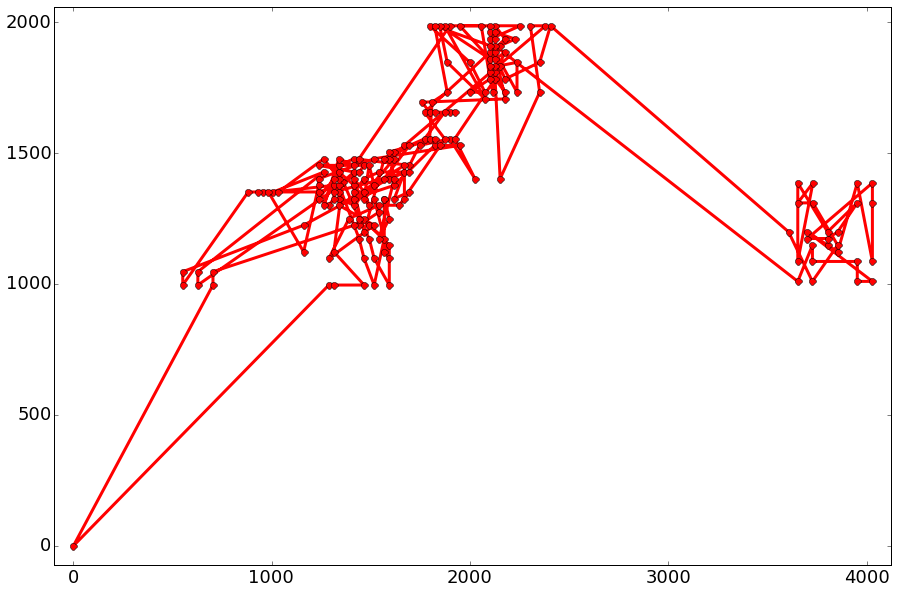

In [140]:
semilla = 12345678
f = 'd198.tsp'

seed(semilla)
name = f[:-4]
problems[name] = TSP(f)
size = len(problems[name].points)
n_iter = size*300
aspiration_tol = 1.
limit_restart = 7
max_vecinos = 30
tabu_tenencia=int(size)
prob_bs = 0.8
prob_greedy = 0.1
prob_aleatorio = "restante"
ts_solutions[name] = problems[name].tabu_search(n_iter, max_vecinos, tabu_tenencia, aspiration_tol, limit_restart)
print(ts_solutions[name].cost)
problems[name].print_solution(ts_solutions[name])

In [ ]:
for name in problems:
    print (name 
           + '\n\t SA: '   + str(sa_solutions[name].cost)
           + '\n\t Best: ' + str(best_solutions[name]))
    problems[name].print_solution(sa_solutions[name])